In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
import random 

np.random.seed(42)
tf.random.set_seed(42)


In [2]:
def load_data(data_dir, img_size=(128,128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace('.jpg', '_mask.jpg'))

            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')

            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [3]:
train_dir = '/kaggle/input/bp-datasets/split_datasets/train'
val_dir = '/kaggle/input/bp-datasets/split_datasets/val'
test_dir = '/kaggle/input/bp-datasets/split_datasets/test'

X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test= load_data(test_dir)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(608, 128, 128, 3)
(608, 128, 128, 1)
(110, 128, 128, 3)
(110, 128, 128, 1)
(55, 128, 128, 3)
(55, 128, 128, 1)


In [5]:
def augment_data(images, masks, num_aug=2):
    
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    aug_images = []
    aug_masks = []
    
    # 원본 데이터 추가
    aug_images.extend(images)
    aug_masks.extend(masks)
    
    # 각 이미지에 대해 증강 데이터 생성
    for idx in range(len(images)):
        image = images[idx]
        mask = masks[idx]
        
        # 이미지와 마스크를 4D 텐서로 변환 (BatchSize=1)
        img_tensor = np.expand_dims(image, 0)
        mask_tensor = np.expand_dims(mask, 0)
        
        # 랜덤 시드 설정 (이미지와 마스크가 동일하게 변형되도록)
        seed = np.random.randint(1000)
        
        # 지정된 수만큼 증강 데이터 생성
        for _ in range(num_aug):
            # 이미지 증강
            datagen.fit(img_tensor)
            aug_img_iter = datagen.flow(img_tensor, seed=seed, batch_size=1)
            aug_img = next(aug_img_iter)[0]
            
            # 마스크 증강 (동일한 변환 적용)
            datagen.fit(mask_tensor)
            aug_mask_iter = datagen.flow(mask_tensor, seed=seed, batch_size=1)
            aug_mask = next(aug_mask_iter)[0]
            
            aug_images.append(aug_img)
            aug_masks.append(aug_mask)
    
    return np.array(aug_images), np.array(aug_masks)

In [6]:
# 학습 데이터만 증강 (각 이미지당 2개의 증강 데이터 생성)
X_train, y_train = augment_data(X_train, y_train, num_aug=2)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(1824, 128, 128, 3)
(1824, 128, 128, 1)
(110, 128, 128, 3)
(110, 128, 128, 1)
(55, 128, 128, 3)
(55, 128, 128, 1)


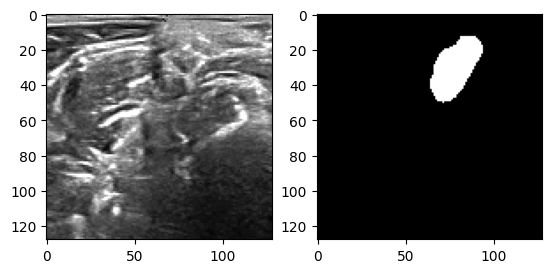

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(X_train[100], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(y_train[100], cmap='gray')

In [9]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv7)
    
    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
def build_unet_dilated(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    # First block - normal convolution to capture fine details
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', dilation_rate=2)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second block - increasing dilation rate
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=4)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Third block - larger dilation rate for broader context
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=4)(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=8)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge - maximum dilation rate for largest receptive field
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=8)(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=16)(conv4)
    
    # Decoder - gradually decreasing dilation rates
    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=4)(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=4)(conv7)
    
    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(conv8)
    
    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
def build_unet_same_dilated(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    # First block
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', dilation_rate=2)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second block
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Third block
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=2)(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', dilation_rate=2)(conv4)
    
    # Decoder
    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', dilation_rate=2)(conv7)
    
    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(conv8)
    
    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', dilation_rate=2)(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', dilation_rate=2)(conv9)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
def build_unet_separable(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    # First block
    conv1 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Second block
    conv2 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Third block
    conv3 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = layers.SeparableConv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.SeparableConv2D(256, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    # First block
    up7 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.SeparableConv2D(128, 3, activation='relu', padding='same')(conv7)
    
    # Second block
    up8 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.SeparableConv2D(64, 3, activation='relu', padding='same')(conv8)
    
    # Third block
    up9 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.SeparableConv2D(32, 3, activation='relu', padding='same')(conv9)
    
    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
model = build_unet_same_dilated()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 128)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 128)    │        131,200 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 256)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 128)    │        295,040 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 128)    │        147,584 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 64, 64, 64)     │         32,832 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
def dice_coef(y_true, y_pred, smooth=1e-6): # 다이스 계수
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    intersection = tf.cast(intersection, dtype=tf.float32)
    
    y_true = tf.reduce_sum(y_true)
    y_pred = tf.reduce_sum(y_pred)
    
    result = (2.0 *(intersection) + smooth) / (y_true + y_pred + smooth)
    
    return result
    
def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
    
def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    dice_loss_value = dice_loss(y_true, y_pred)
    
    return a*dice_loss_value+ (1-a)*logit_loss_value

In [15]:
model.compile(optimizer='adam',
    loss= combined_loss,
    metrics=[dice_coef])

In [16]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_dice_coef', # validation dice coefficient
    factor=0.9, # learning rate￿ 10% ￿￿ 기존 0.9
    patience=3, # 3 epoch ￿￿ ￿￿￿ ￿기존 3￿ ￿
    min_lr=1e-6, # ￿￿ learning rate
    mode='max', # dice coefficient￿ ￿￿￿￿ ￿￿
verbose=1
)
        
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_unet_model.keras', # ￿￿￿ ￿￿￿ ￿￿￿
    monitor='val_dice_coef', # validation dice coefficient ￿￿￿￿
    save_best_only=True, # ￿￿ ￿￿ ￿￿￿ ￿￿
    mode='max',          # dice coefficient￿ ￿￿￿￿ ￿￿
    verbose=1
)

In [17]:
history = model.fit(X_train, y_train,
                    batch_size=16,  # 기존 16
                    epochs=50,    # 기존 50
                    validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, model_checkpoint],
                    shuffle=True              # 데이터 셔플링
)

Epoch 1/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - dice_coef: 0.0035 - loss: 0.9600
Epoch 1: val_dice_coef improved from -inf to 0.00000, saving model to best_unet_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - dice_coef: 0.0035 - loss: 0.9600 - val_dice_coef: 1.1786e-10 - val_loss: 0.9545 - learning_rate: 0.0010
Epoch 2/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.2106 - loss: 0.7534
Epoch 2: val_dice_coef improved from 0.00000 to 0.63607, saving model to best_unet_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - dice_coef: 0.2139 - loss: 0.7502 - val_dice_coef: 0.6361 - val_loss: 0.3497 - learning_rate: 0.0010
Epoch 3/50
113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - dice_coef: 0.6565 - loss: 0.3286
Epoch 3: val_dice_coef improved from 0.63607 to 0.68899, saving model to best_unet_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - dice_coef: 0.6568 - loss: 0.3284 - val_dice_coef: 0.6890 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 4/50
113/11

In [18]:
best_model = tf.keras.models.load_model('best_unet_model.keras',
    custom_objects={
        'combined_loss': combined_loss,
        'dice_coef': dice_coef})

start_time = tf.timestamp()
test_loss, test_dice = best_model.evaluate(X_test, y_test)
end_time = tf.timestamp()
print(f"Inference time: {end_time - start_time} seconds")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - dice_coef: 0.5661 - loss: 0.4177
Inference time: 5.719151020050049 seconds


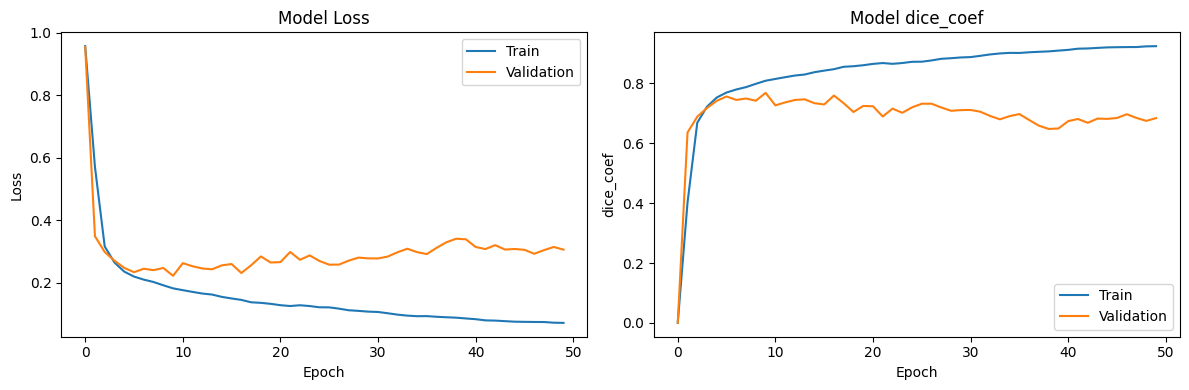

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='lower right')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


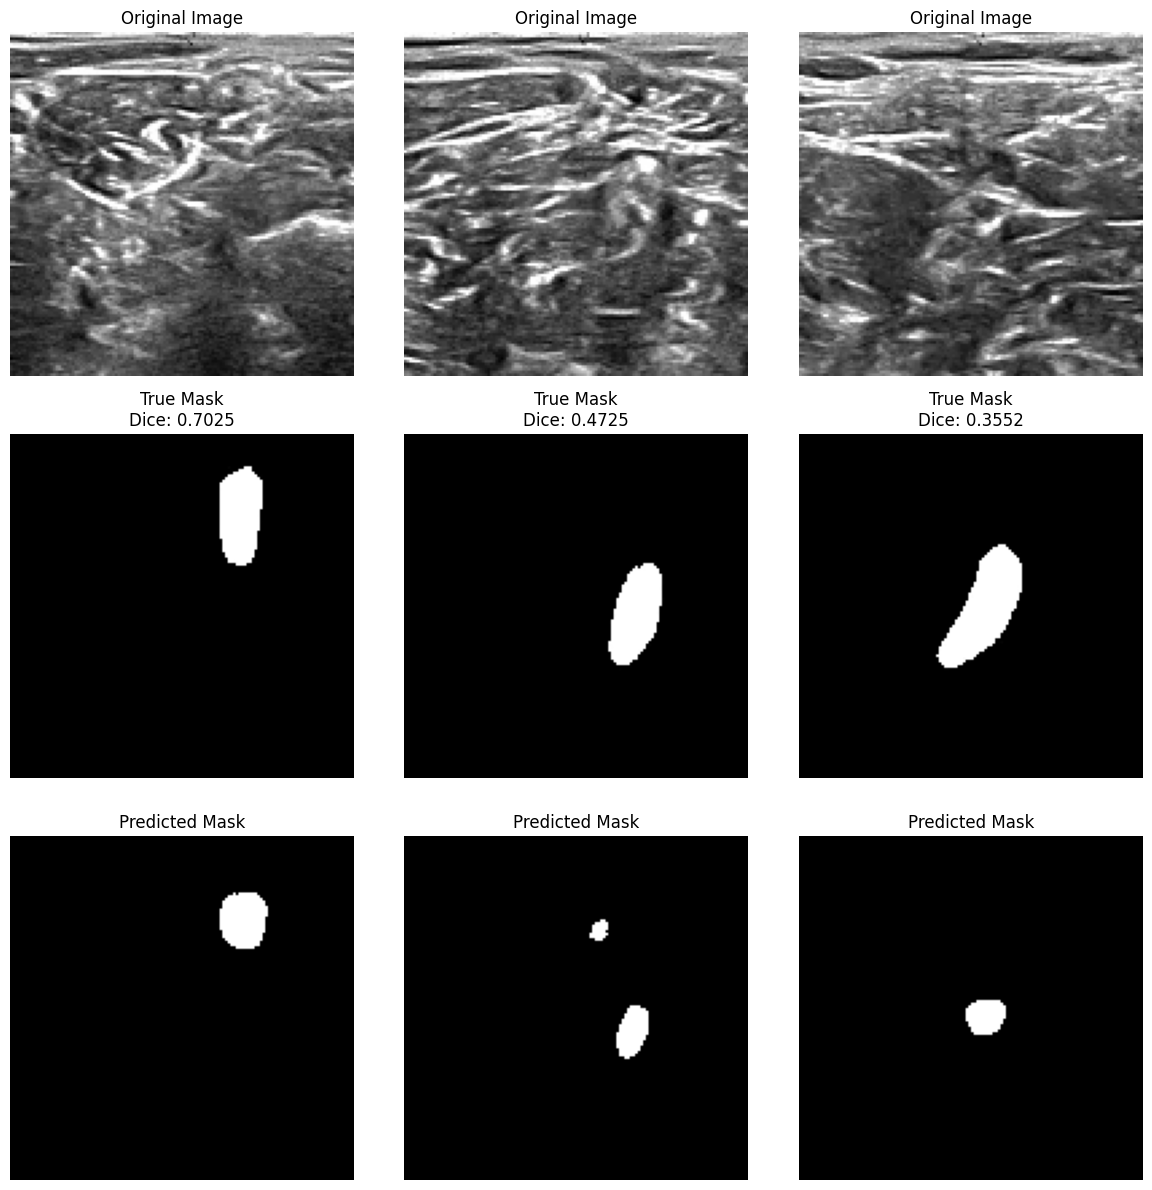

In [20]:
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])
    predictions = (predictions > 0.5).astype(np.float32)
    
    plt.figure(figsize=(4 * num_samples, 12))
    for i in range(num_samples):
        # 원본 이미지 출력
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # 실제 마스크 출력
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title(f'True Mask\nDice: {dice_coef(y[i:i+1], predictions[i:i+1]).numpy():.4f}')
        plt.axis('off')
        
        # 예측 마스크 출력
        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 함수 호출 예시
visualize_results(model, X_test, y_test)

In [21]:
import tensorflow as tf
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def calculate_flops(model, input_shape=(1, 128, 128, 3)):
    # 모델을 ConcreteFunction으로 변환
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec(input_shape, tf.float32)
    )

    # Graph를 Frozen하여 FLOPs 계산
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph

    # TensorFlow Profiler를 사용하여 FLOPs 계산
    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()

    # tf.compat.v1.profiler을 사용하여 계산
    flops = tf.compat.v1.profiler.profile(
        graph=frozen_graph,
        run_meta=run_meta,
        options=opts
    )

    return flops.total_float_ops  # Total FLOPs


def measure_inference_time(model, X, num_samples=10):
    start_time = time.time()
    for _ in range(num_samples):
        model.predict(X[:1])
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples
    return avg_inference_time

# FLOPs 계산
flops = calculate_flops(model)
print(f"FLOPs: {flops / 1e9:.3f} GFLOPs")


FLOPs: 4.615 GFLOPs
